In [1]:
# Import and install dependencies

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
import datetime as dt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Input, RNN, GRU, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [2]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils 

def mediapipe_detection (image, model):    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      # Convert the image from BGR to RGB color space
    image.flags.writeable = False                       # Set the writeable flag of the image to False to prevent modification   
    results = model.process(image)                      # Process the image using the provided model (presumably the holistic model)   
    image.flags.writeable = True                        # Set the writeable flag of the image back to True for further processing   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)      # Convert the image back from RGB to BGR color space
    return image, results

def draw_styled_landmarks(image, results):
    # Draw left hand Connection
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color = (121, 22, 76), thickness = 2, circle_radius = 4),
                                mp_drawing.DrawingSpec(color = (121, 44, 250), thickness =2, circle_radius =2)
                                ) 
    
    # Draw right hand Connection   
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color = (245, 117, 66), thickness = 1, circle_radius = 4),
                                mp_drawing.DrawingSpec(color = (245, 66, 230), thickness =1, circle_radius =2)
                                )   
    
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [3]:
# labelling

DATA_PATH = 'dataset/dta-25'

actions = np.array(['A', 'B', 'C', 'D', 'E', 'F', 
                    'G', 'H', 'I', 'J', 'K', 'L', 
                    'M', 'N', 'O', 'P', 'Q', 'R', 
                    'S', 'T', 'U', 'V', 'W', 'X', 
                    'Y', 'Z', 'Halo', 'Perkenalkan', 'Nama',
                    'Saya', 'Senang', 'Bertemu', 'Kamu'])

sequence_length = 30
label_map = {label:num for num, label in enumerate(actions)}
label_map


{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'Halo': 26,
 'Perkenalkan': 27,
 'Nama': 28,
 'Saya': 29,
 'Senang': 30,
 'Bertemu': 31,
 'Kamu': 32}

In [41]:
import cv2

# Read an image file
img = cv2.imread('dataset/dti-25/A/0/0.jpg')
height, width, _ = img.shape

print(f'Width: {width}')
print(f'Height: {height}')


Width: 640
Height: 480


In [4]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [5]:
np.array(sequences).shape

(825, 30, 126)

In [6]:
np.array(labels).shape

(825,)

In [7]:
# Convert to numpy array
sequences = np.array(sequences)
labels = np.array(labels)

In [8]:
# Reshape data to add channel dimension
X = sequences.reshape((sequences.shape[0], sequences.shape[1], sequences.shape[2], 1, 1))

# One-hot encode labels
y = tf.keras.utils.to_categorical(labels, num_classes=len(actions))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense
import tensorflow as tf

def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters=4, kernel_size=(1, 1), activation='tanh', data_format="channels_last",
                        recurrent_dropout=0.2, return_sequences=True, input_shape=(30, 126, 1, 1)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=8, kernel_size=(2, 2), activation='tanh', data_format="channels_last",
                        recurrent_dropout=0.2, return_sequences=True, padding='same'))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=14, kernel_size=(2, 2), activation='tanh', data_format="channels_last",
                        recurrent_dropout=0.2, return_sequences=True, padding='same'))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=16, kernel_size=(2, 2), activation='tanh', data_format="channels_last",
                        recurrent_dropout=0.2, return_sequences=True, padding='same'))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    
    model.add(Flatten())
    
    model.add(Dense(len(actions), activation="softmax"))
    
    model.summary()
    
    return model

convlstm_model = create_convlstm_model()
print("Model created successfully!")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 126, 1, 4)     96        
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 63, 1, 4)     0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 30, 63, 1, 4)     0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 63, 1, 8)      1568      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 32, 1, 8)     0         
 3D)                                                             
                                                        

In [11]:
# Define the custom callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if (logs.get('accuracy') > 0.98) and (logs.get('val_accuracy') > 0.98):
            print("\nCategorical accuracy is higher than 0.91 and loss is lower than 0.19, stopping training!")
            self.model.stop_training = True

# Instantiate the custom callback
custom_callback = myCallback()

# Set up the TensorBoard callback
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# Combine both callbacks
callback = [custom_callback, tb_callback]

In [12]:
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [13]:
convlstm_model_training_history = convlstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 800, batch_size = 12, shuffle = True, callbacks = callback)

Epoch 1/800
66/66 [==============================] - 638s 9s/step - loss: 3.1812 - accuracy: 0.0728 - val_loss: 2.6874 - val_accuracy: 0.2381
Epoch 2/800
66/66 [==============================] - 589s 9s/step - loss: 2.4004 - accuracy: 0.2184 - val_loss: 1.9721 - val_accuracy: 0.2381
Epoch 3/800
66/66 [==============================] - 689s 10s/step - loss: 1.8253 - accuracy: 0.3959 - val_loss: 1.2857 - val_accuracy: 0.5714
Epoch 4/800
66/66 [==============================] - 643s 10s/step - loss: 1.4326 - accuracy: 0.5160 - val_loss: 0.9270 - val_accuracy: 0.7619
Epoch 5/800
66/66 [==============================] - 592s 9s/step - loss: 1.0662 - accuracy: 0.6488 - val_loss: 0.5665 - val_accuracy: 0.8571
Epoch 6/800
66/66 [==============================] - 609s 9s/step - loss: 0.8524 - accuracy: 0.7203 - val_loss: 0.6338 - val_accuracy: 0.7857
Epoch 7/800
66/66 [==============================] - 586s 9s/step - loss: 0.6880 - accuracy: 0.7599 - val_loss: 0.3771 - val_accuracy: 0.8810
Epoc

In [14]:
convlstm_model.save('33C_ConvLSTM_acc098_loss01_s25_ke2.h5')

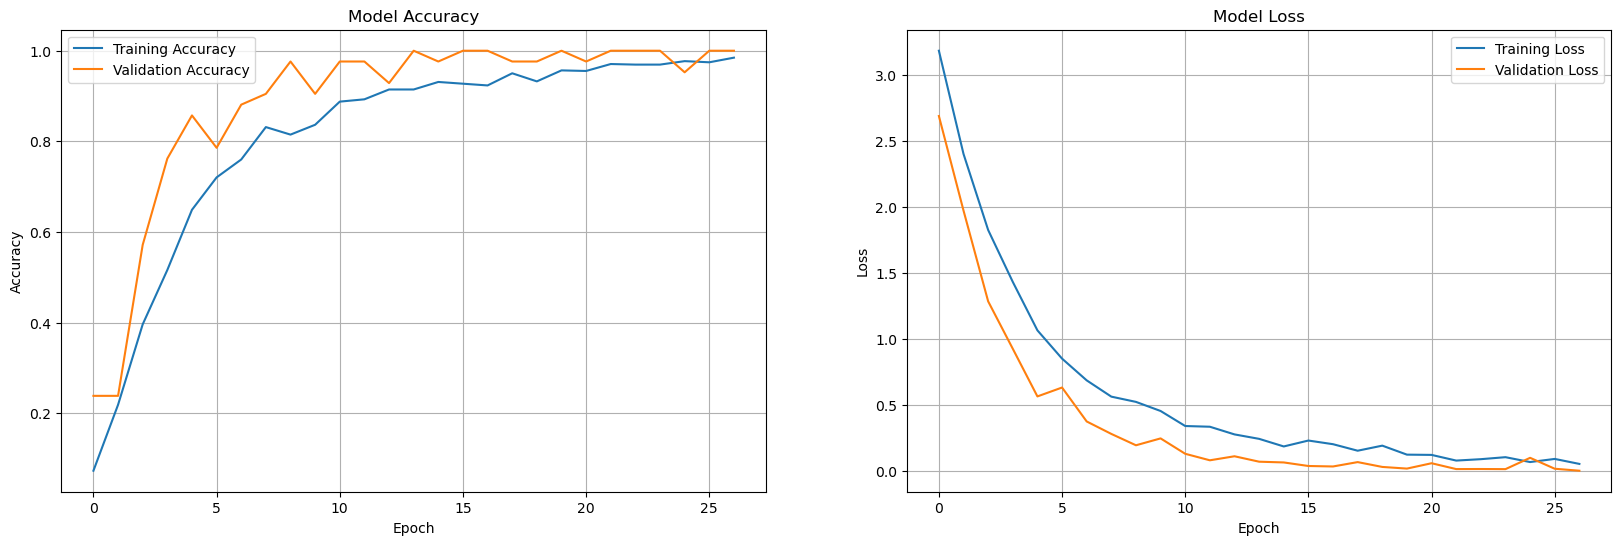

In [16]:
# Assuming convlstm_model_training_history is the variable holding the history after training
history = convlstm_model_training_history.history

# Extract accuracy, validation accuracy, loss, and validation loss
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot accuracy
ax1.plot(accuracy, label='Training Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot loss
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.show()


2/2 [==============================] - 1s 48ms/step


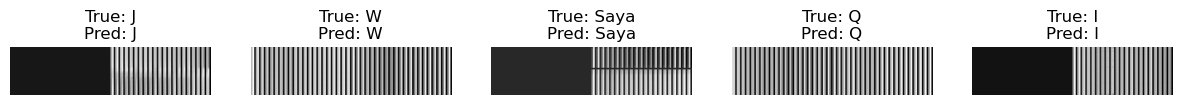

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix

# Generate predictions on the test set
y_pred = convlstm_model.predict(X_test)

# Convert predictions and true labels from one-hot encoding to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Visualize sample predictions
num_samples = 5
sample_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i+1)
    # Assuming the first frame from the sequence for visualization
    frame = X_test[idx][:, :, 0, 0].reshape((30, 126))  # Reshape for visualization
    
    # Display the first frame of the sequence
    plt.imshow(frame, cmap='gray')
    plt.title(f"True: {actions[y_true_classes[idx]]}\nPred: {actions[y_pred_classes[idx]]}")
    plt.axis('off')

plt.show()